In [1]:
# === EXECUTE THIS CELL ===

import numpy as np
from scipy.fft import fft2, ifft2
import sympy as sp
from sympy import *

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import animation
from matplotlib.animation import PillowWriter
from IPython.display import display, Image

import pandas as pd
import seaborn as sns
sns.set_context("talk")


def cahn_hilliard(c0, M, kappa, W, noise, Nsteps, rng_seed):
    # === Fixed parameters ===
    N = 64
    dx = dy = 1.0
    L = N * dx
    dt = 0.1
    energy_interval = 50
    snapshot_base = 375

    # === Initialization ===
    rng = np.random.default_rng(rng_seed)
    c = np.empty((Nsteps, N, N), dtype=np.float32)
    c[0] = c0 + noise * rng.standard_normal(size=(N, N))

    # FFT wavenumbers
    kx = np.fft.fftfreq(N, d=dx) * 2 * np.pi
    ky = np.fft.fftfreq(N, d=dy) * 2 * np.pi
    KX, KY = np.meshgrid(kx, ky, indexing='ij')
    K2 = KX**2 + KY**2

    # Dealiasing mask (2/3 rule)
    kmax_dealias = kx.max() * 2.0 / 3.0
    dealias = (np.abs(KX) < kmax_dealias) & (np.abs(KY) < kmax_dealias)

    # === Free energy derivative ===
    def dfdc(c):
        return 2 * W * (c * (1 - c)**2 - (1 - c) * c**2)

    # === Compute total free energy ===
    def compute_energy(c):
        f_bulk = W * c**2 * (1 - c)**2
        grad_c_x = np.gradient(c, dx, axis=0)
        grad_c_y = np.gradient(c, dy, axis=1)
        grad_energy = 0.5 * kappa * (grad_c_x**2 + grad_c_y**2)
        return np.sum(f_bulk + grad_energy) * dx * dy

    # === Spectral buffer ===
    c_hat = fft2(c[0])
    dfdc_hat = np.empty((N, N), dtype=np.complex64)

    # === Energy tracking ===
    energy_records = []

    # === Precompute snapshot steps ===
    snapshot_steps = [0]
    step = snapshot_base
    while step < Nsteps:
        snapshot_steps.append(step)
        step *= 2

    # === Time-stepping loop (Cahn-Hilliard solver) ===
    for i in range(Nsteps):
        if i > 0:
            dfdc_hat[:] = fft2(dfdc(c[i - 1]))
            dfdc_hat *= dealias
            c_hat[:] = (c_hat - dt * K2 * M * dfdc_hat) / (1 + dt * M * kappa * K2**2)
            c[i] = ifft2(c_hat).real

        # Energy tracking every energy_interval steps
        if i % energy_interval == 0:
            energy = compute_energy(c[i])
            energy_records.append({'step': i, 'time': i * dt, 'energy': energy})

        # Plot snapshot if it's a scheduled snapshot step
        if i in snapshot_steps or i == Nsteps-1:
            plt.figure(figsize=(2.5, 2.5))
            plt.imshow(c[i], cmap='plasma', vmin=0.0, vmax=1.0)
            plt.title(rf'$c_0={c0}$' + f'\nstep {i}')
            plt.axis('off')
            plt.tight_layout()
            plt.show()

    # === Convert energy records to DataFrame ===
    energy_df = pd.DataFrame(energy_records)

    # === Mass conservation sanity check ===
#    final_mass = c[-1].sum() * dx**2 / L**2
#    mass_error = np.abs(c[-1].sum() - c[0].sum()) / c[0].sum()
#    print(f"\nFinal mass = {final_mass:.3f} ± {mass_error:.1e}")
    
    sns.lineplot(x=energy_df["step"], y=energy_df["energy"]/N**2)
    plt.xlabel('Step')
    plt.ylabel('Free Energy')
    plt.grid(alpha=0.5)
    plt.tight_layout()
    plt.show()

    return

<details>
<summary>What are we doing? (technical explanation)</summary>

This program solves the Cahn–Hilliard phase-field equation using a spectral semi-implicit method with Fast Fourier Transforms (FFT) and periodic boundary conditions. We gratefully acknowledge `@elvissoares` for the spectral method implementation.

The FFT lets us solve PDEs efficiently in Fourier space, where differential operators become simple algebraic expressions. This is especially useful for the Cahn–Hilliard equation, which involves fourth-order derivatives like $\nabla^4 c$, expensive to compute with finite differences.

In Fourier space:

The Laplacian simplifies to:

$$
\mathcal{F}[\nabla^2 c] = -k^2 \cdot \hat{c}(k)
$$

The Cahn–Hilliard equation:

$$
\frac{\partial c}{\partial t} = M \nabla^2 \left( \frac{\delta F}{\delta c} \right)
$$

becomes algebraic after FFT:

$$
\hat{c}(k, t + \Delta t) = \frac{\hat{c}(k, t) - \Delta t \cdot M \cdot k^2 \cdot \widehat{\delta F/\delta c}}{1 + \Delta t \cdot M \cdot \kappa \cdot k^4}
$$

This avoids costly numerical differentiation and enables semi-implicit time integration.

</details>

# Exercise: Cahn-Hilliard Equation and Spinodal Decomposition

The free energy density is coded as:
$$
f(c) = Wc^2(1-c)^2,
$$
where $0 \leq c \leq 1$. All of the parameters used in the simulation are reduced (nondimensional). 

## Task (a)
In the next cell, write the Python expression for the free energy density.
Run the code snippet below to visualize the free energy density as a function of the concentration.
You should recognize the characteristic shape of this curve from theory.

- Identify the stationary points.
- Locate the inflection points.
- Discuss the implications of this functional analysis for spinodal decomposition.

In [2]:
def f_c(W, c):
    return W * c**2 * (1 - c)**2

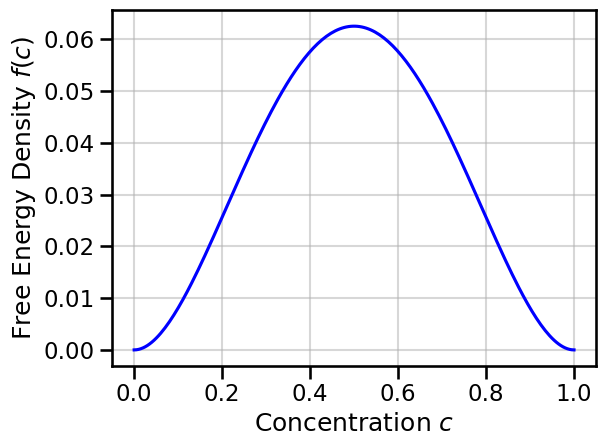

In [3]:
# Parameters
W = 1.0  # Energy parameter

# Create 200 equally spaced concentration values from 0 to 1
c = np.linspace(0, 1, 200)

# Plot using seaborn styling
plt.plot(c, f_c(W,c), color='blue')

# Labels and title
plt.xlabel('Concentration $c$')
plt.ylabel('Free Energy Density $f(c)$')

plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

- Cross-check your analysis by executing the following snippet:

In [4]:
# Define symbols
c, W = sp.symbols('c W', real=True)

# First and second derivatives
df_dc = sp.diff(f_c(W,c), c)
d2f_dc2 = sp.diff(df_dc, c)

# Solve for stationary points (df/dc = 0)
stationary_points = sp.solve(df_dc, c)
print(f"Stationary points = {sp.N(stationary_points[0]):.2f}, {sp.N(stationary_points[1]):.2f} and {sp.N(stationary_points[2]):.2f}")

# Solve for inflection points (d²f/dc² = 0)
inflection_points = sp.solve(d2f_dc2, c)
print(f"Inflection points = {sp.N(inflection_points[0]):.2f} and {sp.N(inflection_points[1]):.2f}")

Stationary points = 0.00, 0.50 and 1.00
Inflection points = 0.21 and 0.79


## Task (b)
Run the following program for various initial concentrations $c_0 = 0.5, 0.6, 0.7$, using a mobility of $0.5$ and a gradient coefficient of $0.6$, for $50000$ timesteps.

The simulation produces snapshots showing the time evolution of the microstructure and a final plot of the free energy evolution over time.

When you adjust the sliders, the simulation executes automatically.

For each simulation, compare the initial energy value to the free energy density curve you plotted at the beginning.  
Does the initial energy agree with your expectations based on the free energy density curve?

> **Hint:** To avoid overwriting your previous results, duplicate the relevant code cells and update the initial concentration value in each copy. This allows you to run multiple simulations sequentially and compare the outcomes.

In [6]:
import ipywidgets as widgets
from ipywidgets import interact

interact(
    cahn_hilliard,
    c0=widgets.FloatSlider(value=0.75, min=0.0, max=1.0, step=0.1, description='c₀'),
    M=widgets.FloatSlider(value=0.5, min=0.1, max=2.0, step=0.1, description='M'),
    kappa=widgets.FloatSlider(value=0.6, min=0.1, max=2.0, step=0.1, description='κ'),
    W=widgets.FloatSlider(value=1.0, min=0.1, max=2.0, step=0.1, description='W'),
    noise=widgets.FloatSlider(value=0.01, min=0.002, max=0.5, step=0.001, description='Noise'),
    Nsteps=widgets.IntSlider(value=10000, min=1000, max=50000, step=1000, description='Steps'),
    rng_seed=widgets.IntText(value=12345, description='Seed')
);

interactive(children=(FloatSlider(value=0.75, description='c₀', max=1.0), FloatSlider(value=0.5, description='…

#### Task (c)
Set $c_0 = 0.8$ while keeping all other parameters unchanged. You will notice that the concentration field does not evolve. Explain why this happens.


#### Task (d)
Fix the problem by adjusting the appropriate parameter. For which new value do you observe the nucleation of the secondary phase?
> **Hint:** The appropriate parameter might need to be changed even by orders of magnitude.